**This notebook is for:**
1. Testing causalML.
https://antonsruberts.github.io/causalml-test/

In [ ]:
# !pip install statsmodels --upgrade
# !pip install matplotlib --upgrade
# !pip install scipy --upgrade
# !pip install -U scikit-learn
# !pip install -U pip
# !pip install numpy
# !pip install causalml
# !pip install statsmodels --upgrade 
# !pip install imbalanced-learn
# !pip install pandas --upgrade
# !pip install pyarrow

In [1]:
import matplotlib as m
print(m.__version__)

3.5.1


In [2]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

adding utils to path 


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings

from causalml.inference.meta  import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseXRegressor
from causalml.dataset import *
from causalml.metrics import *
from xgboost import XGBClassifier, XGBRegressor

from utilities import *
from user_model_evaluation import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [5]:
master = pd.read_parquet('MASTER/202203221434.parquet')

In [7]:
#model vars
treatment_var = 'W'
target_var = 'Y'
exclude_vars = ['CUS_CUST_ID', 'SENT_DATE'] + [treatment_var] + [target_var]
model_vars = list(set(master.columns) - set(exclude_vars))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(master,
                                                    master[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    stratify = master[target_var],
                                                    test_size=0.20)

test_treatment = X_test[treatment_var]

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state= 142,
                                                  shuffle=True,
                                                  stratify = y_train,
                                                  test_size=0.33)

train_treatment = X_train[treatment_var]
val_treatment = X_val[treatment_var]

In [9]:
rus = RandomUnderSampler(random_state=0)
X_undersampled, y_undersampled = rus.fit_resample(X_train[model_vars + [treatment_var]], y_train)

In [10]:
%%time
learner_s = BaseSClassifier(learner=XGBClassifier(use_label_encoder=True, eval_metric='mlogloss',n_jobs = -1))
learner_s.fit(X=X_train[model_vars], treatment=train_treatment, y=y_train)

learner_t = BaseTClassifier(learner=XGBClassifier(use_label_encoder=True, eval_metric='mlogloss',n_jobs = -1))
learner_t.fit(X=X_train[model_vars], treatment=train_treatment, y=y_train)

# Ojo typo en docstring (https://github.com/uber/causalml/issues/249)
learner_x = BaseXClassifier(effect_learner=XGBClassifier(use_label_encoder=True, eval_metric='mlogloss',n_jobs = 20),
                           outcome_learner=XGBClassifier(use_label_encoder=True, eval_metric='mlogloss',n_jobs = 15))
cate_x = learner_x.fit(X=X_undersampled[model_vars], treatment=X_undersampled.W.ravel(), y=y_undersampled)

2022-03-22 15:23:30 Generating propensity score
2022-03-22 15:24:35 Calibrating propensity scores.


CPU times: user 3h 15min 35s, sys: 2min 40s, total: 3h 18min 16s
Wall time: 12min 28s


In [11]:
s_cate = learner_s.predict(X_test[model_vars], treatment=test_treatment, y=y_test)
t_cate = learner_t.predict(X_test[model_vars], treatment=test_treatment, y=y_test)
x_cate = learner_x.predict(X_test[model_vars], treatment=test_treatment, y=y_test)

2022-03-22 15:35:32 Error metrics for group 1
2022-03-22 15:35:32      AUC   (Control):     0.7431
2022-03-22 15:35:32      AUC (Treatment):     0.7649
2022-03-22 15:35:32 Log Loss   (Control):     0.0739
2022-03-22 15:35:32 Log Loss (Treatment):     0.0928
2022-03-22 15:35:32 Error metrics for group 1
2022-03-22 15:35:32      AUC   (Control):     0.6564
2022-03-22 15:35:32      AUC (Treatment):     0.7618
2022-03-22 15:35:32 Log Loss   (Control):     0.0849
2022-03-22 15:35:32 Log Loss (Treatment):     0.0932
2022-03-22 15:35:32 Generating propensity score
2022-03-22 15:37:07 Error metrics for group 1
2022-03-22 15:37:07      AUC   (Control):     0.7030
2022-03-22 15:37:07      AUC (Treatment):     0.7479
2022-03-22 15:37:07 Log Loss   (Control):     0.6597
2022-03-22 15:37:07 Log Loss (Treatment):     0.6301


In [12]:
set_ = {'S-meta':s_cate[:,0].tolist() ,
        'T-meta':t_cate[:,0].tolist(),
        'X-meta':x_cate[:,0].tolist()}

result = {}
vars_ = ['lift_top10','uplift_top30',
         'gini_coef','gain_top30','qini_coeff']
for key,val in set_.items():
    a,b,c,d,e = EvalIncrementalModels(y_test,
                                      test_treatment,
                                      val,
                                      plot = False)
    
    result[key] = {x:y for x,y in zip(vars_,[a,b,c,d,e])}

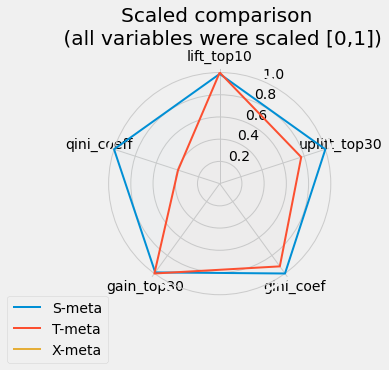

In [13]:
r = pd.DataFrame(result)
# r_normalized = r.apply(lambda x: (x - r.mean(axis = 1))/(r.std(axis = 1)))
r_normalized = r.apply(lambda x: (x - r.min(axis = 1))/(r.max(axis = 1)  - r.min(axis = 1)))
#Por normalizar se puede perder un modelo (el que tenga las variables con valores mas bajos)
categories = r_normalized.index
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

for model in r_normalized .columns:
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories)
    
    values=r_normalized[model].values.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"{model}")
    ax.fill(angles, values, alpha=0.010)
    ax.legend(loc='upper right', bbox_to_anchor=(0.05, 0.05))
    plt.title('Scaled comparison \n (all variables were scaled [0,1])')

In [18]:
r

,S-meta,T-meta,X-meta
lift_top10,3.154394,3.178319,1.223647
uplift_top30,0.033455,0.029110,0.014427
gini_coef,0.321000,0.292000,-0.045000
gain_top30,58.660000,59.010000,30.050000
qini_coeff,0.305000,0.076000,-0.073000


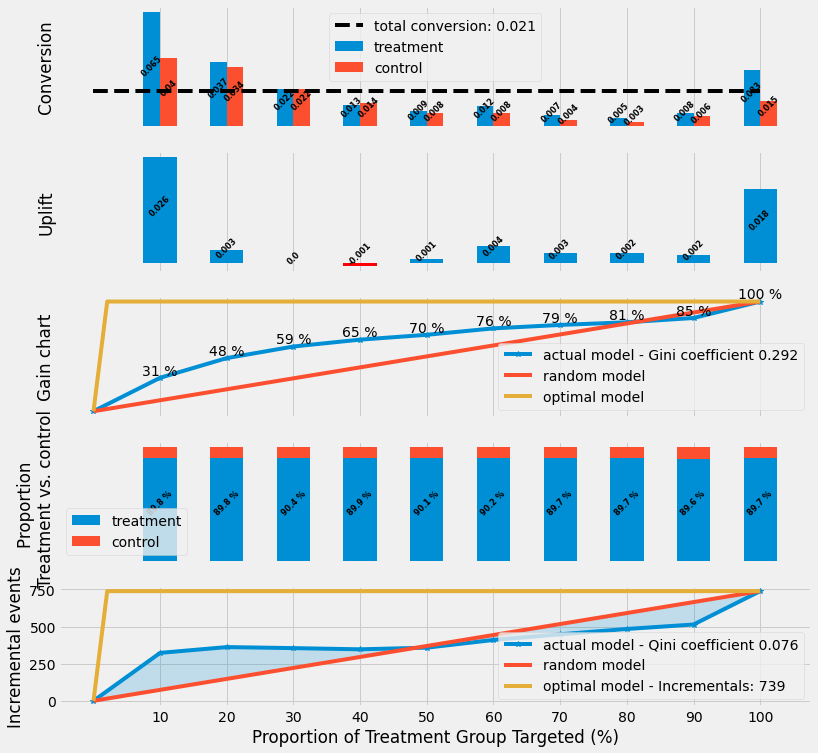

In [15]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           t_cate[:,0].tolist(),
                                                           plot = True)

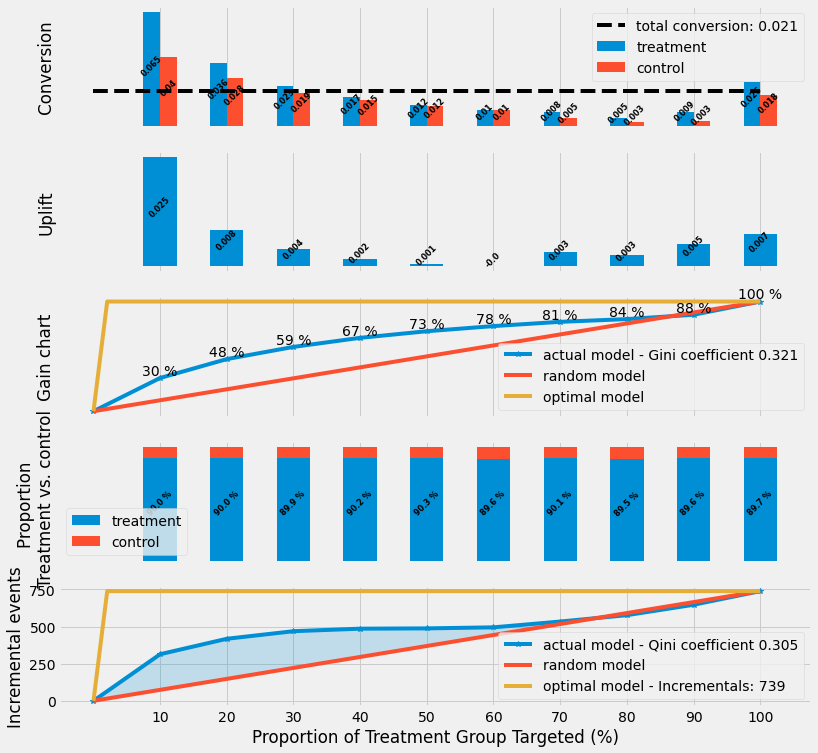

In [16]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           s_cate[:,0].tolist(),
                                                           plot = True)

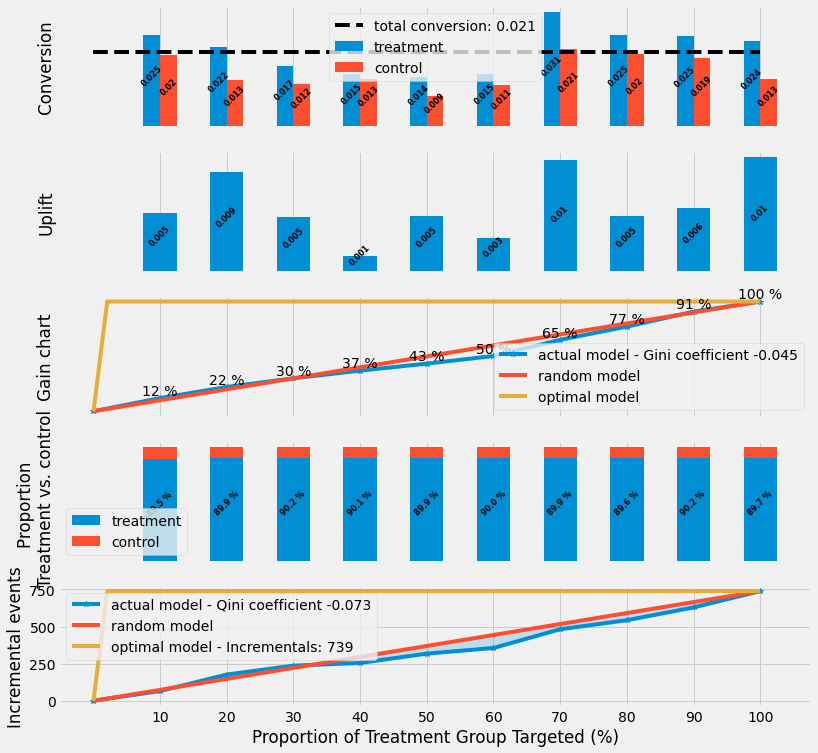

In [17]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           x_cate[:,0].tolist(),
                                                           plot = True)

In [ ]:
df_test = X_test
df_test['Y_'] =  t_cate[:,0].tolist()

In [ ]:
df_ = get_qini(df = df_test,outcome_col='Y',treatment_col='W',treatment_effect_col='Y_',normalize= True)

In [ ]:
df_

In [ ]:
plt.plot(df_.CUS_CUST_ID)
plt.plot(df_.Random)

In [ ]:
# import causalml.dataset as data
# dir(data)

In [ ]:
# dataset = make_uplift_classification(n_samples=1000,
#                            treatment_name=['control', 'treatment1'],
#                            y_name='conversion',
#                            n_classification_features=10,
#                            n_classification_informative=5,
#                            n_uplift_increase_dict={'treatment1': 4},
#                            n_uplift_decrease_dict={'treatment1': 3},
#                            delta_uplift_increase_dict={'treatment1': 0.1},
#                            positive_class_proportion=0.1)

In [ ]:
# Generate synthetic data using mode 1
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)
# tau: individual treatment effect
# b: expected outcome
# e: propensity of receiving treatment
# y: outcome variable
# X: covariates

In [ ]:
# Ready-to-use S-Learner using LinearRegression
learner_s = LRSRegressor()
ate_s = learner_s.estimate_ate(X=X, treatment=treatment, y=y)
print(ate_s)
print('ATE estimate: {:.03f}'.format(ate_s[0][0]))
print('ATE lower bound: {:.03f}'.format(ate_s[1][0]))
print('ATE upper bound: {:.03f}'.format(ate_s[2][0]))

In [ ]:
# XGBTRegressor() vs. BaseTRegressor(learner=XGBRegressor())
# XGBTRegressor() = BaseTRegressor(learner=XGBRegressor()).
# When you use BaseTregressor you can change the model to be used in the Two model approach. 

In [ ]:
# Ready-to-use T-Learner using XGB
learner_t = XGBTRegressor()
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('Using the ready-to-use XGBTRegressor class')
print(ate_t)

# Calling the Base Learner class and feeding in XGB
learner_t = BaseTRegressor(learner=XGBRegressor())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using XGB (same result):')
print(ate_t)

# Calling the Base Learner class and feeding in LinearRegression
learner_t = BaseTRegressor(learner=LinearRegression())
ate_t = learner_t.estimate_ate(X=X, treatment=treatment, y=y)
print('\nUsing the BaseTRegressor class and using Linear Regression (different result):')
print(ate_t)

In [ ]:
# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y)

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y)

In [ ]:
np.subtract(tau , results[:,x]).tolist()

In [ ]:
diff = []
results = np.hstack([cate_s,cate_t,cate_x,cate_x_no_p])
labels = {0: 'single model lr',1:'two model XGBoost-reg',2: 'x model XGBoost-re w/ e', 3:'x model XGBoost-re wo/ e'}
A = []
for x in range(4):
    diff.append(np.subtract(tau , results[:,x]))
    

In [ ]:
results[:,3]

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (16,6))
fig.subplots_adjust(hspace = 5)
axs = axs.ravel()
for x in np.arange(0,3,1):
    y = results[:,x+1]
    axs[x].hist(x = y,bins=100,alpha=0.4)
    axs[x].vlines(x = results[:,0], ymin = 0 , ymax = 1000)
    axs[x].set_title(f'{labels[x+1]} \n mean: {np.round(np.mean(y),2)}')

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (16,6))
fig.subplots_adjust(hspace = 5)
axs = axs.ravel()
for x in range(4):
    y = diff[x]
    axs[x].hist(x = y,bins=100,alpha=0.4)
    axs[x].set_title(f'{labels[x]} - \n MAE: {np.round(np.mean(np.abs(y)),2)}')


In [19]:
# https://github.com/uber/causalml/blob/master/examples/uplift_trees_with_synthetic_data.ipynb
from causalml.inference.tree import UpliftTreeClassifier

In [20]:
dataset, x_names = make_uplift_classification(n_samples=1000,
                           treatment_name=['control', 'treatment1'],
                           y_name='conversion',
                           n_classification_features=10,
                           n_classification_informative=5,
                           n_uplift_increase_dict={'treatment1': 4},
                           n_uplift_decrease_dict={'treatment1': 3},
                           delta_uplift_increase_dict={'treatment1': 0.3},#<------------
                           delta_uplift_decrease_dict={'treatment1': 0.1},                    
                           positive_class_proportion=0.1)

In [21]:
# Split data to training and testing samples for model validation (next section)
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=111)

In [22]:
clf = UpliftTreeClassifier(control_name='control')
clf.fit(df_train[x_names].values,
         treatment=df_train['treatment_group_key'].values,
         y=df_train['conversion'].values)
p = clf.predict(df_test[x_names].values,)

In [23]:
df_res = pd.DataFrame(p, columns=clf.classes_)
df_res.head()

,control,treatment1
0,0.099757,0.100257
1,0.041667,0.601351
2,0.041667,0.601351
3,0.099757,0.100257
4,0.041667,0.601351


In [24]:
(df_res.treatment1 - df_res.control ).mean()#<------------

0.27424139175934514

In [25]:
best_treatment = df_res.idxmax(axis=1)

In [26]:
best_treatment

0      treatment1
1      treatment1
2      treatment1
3      treatment1
4      treatment1
          ...    
395    treatment1
396    treatment1
397    treatment1
398    treatment1
399    treatment1
Length: 400, dtype: object